## Synchrotron and Synchrotron Self-Compton crosscheck with jetset
In this notebook I cross check the Synchrotron and Synchrotron Self-Compton SEDs produced by agnpy with those produced by Andrea Tramacere's jetset.      
Jetset is needed to run this notebook
https://github.com/andreatramacere/jetset
https://jetset.readthedocs.io/en/latest/

In [1]:
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import Distance
from agnpy.emission_regions import Blob
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton
import matplotlib.pyplot as plt

### agnpy

In [2]:
# set the spectrum normalisation (total energy in electrons in this case)
spectrum_norm = 1e48 * u.Unit("erg")
# define the spectral function through a dictionary
spectrum_dict = {
    "type": "PowerLaw",
    "parameters": {"p": 2.8, "gamma_min": 1e2, "gamma_max": 1e7}
}
R_b = 1e16 * u.cm
B = 1 * u.G
z = Distance(1e27, unit=u.cm).z
delta_D = 10
Gamma = 10
blob = Blob(R_b, z, delta_D, Gamma, B, spectrum_norm, spectrum_dict)

normalising power-law to total energy density u_e: 2.39e-01 erg / cm3


In [3]:
print(blob)

* spherical emission region
 - R_b (radius of the blob): 1.00e+16 cm
 - V_b (volume of the blob): 4.19e+48 cm3
 - z (source redshift): 0.07
 - d_L (source luminosity distance):1.00e+27 cm
 - delta_D (blob Doppler factor): 1.00e+01
 - Gamma (blob Lorentz factor): 1.00e+01
 - Beta (blob relativistic velocity): 9.95e-01
 - theta_s (jet viewing angle): 5.74e+00 deg
 - B (magnetic field tangled to the jet): 1.00e+00 G
* electron spectrum
 - power law
 - k_e: 9.29e+06 1 / cm3
 - p: 2.80
 - gamma_min: 1.00e+02
 - gamma_max: 1.00e+07



In [5]:
nu = np.logspace(8, 30) * u.Hz

synch = Synchrotron(blob)
ssc = SynchrotronSelfCompton(blob, synch)

# let us compute the SED values at these frequencies
synch_sed = synch.sed_flux(nu)
ssc_sed = ssc.sed_flux(nu)

/Users/cosimo/software/miniconda3/lib/python3.7/site-packages/agnpy/compton.py:24: RuntimeWarning: invalid value encountered in log
  term_1 = 2 * q * np.log(q)


### JetSet

In [6]:
from jetset.jet_model import Jet
jet = Jet(name='ssc',electron_distribution='pl',)
jet.parameters.par_table

name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
str8,str19,object,float64,float64,object,bool,bool
N,electron_density,1 / cm3,100.0,0.0,None,False,False
gmin,low-energy-cut-off,lorentz-factor*,2.0,1.0,1000000000.0,False,False
gmax,high-energy-cut-off,lorentz-factor*,1000000.0,1.0,1000000000000000.0,False,False
p,HE_spectral_slope,,2.0,-10.0,10.0,False,False
R,region_size,cm,5000000000000000.0,1000.0,1e+30,False,False
R_H,region_position,cm,1e+17,0.0,None,False,True
B,magnetic_field,G,0.1,0.0,None,False,False
beam_obj,beaming,Lorentz-factor*,10.0,0.0001,None,False,False
z_cosm,redshift,,0.1,0.0,None,False,False


In [7]:
jet.set_par('B', val=blob.B.value)
# mind the normalisation in jetset is the total electron density (integrated along gamma)
jet.set_par('N', val=blob.n_e_tot.value)
jet.set_par('R', val=blob.R_b.value)
jet.set_par('beam_obj', val=blob.delta_D)
jet.set_par('gmin', val=blob.gamma_min)
jet.set_par('gmax', val=blob.gamma_max)
jet.set_par('p', val=blob.n_e.p)
jet.set_par('z_cosm', val=blob.z)
# switch off synchrotron self absorption
jet.set_gamma_grid_size(1000)
jet.nu_seed_size = 1000
# check the parameters have been updated
jet.parameters.par_table

name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
str8,str19,object,float64,float64,object,bool,bool
N,electron_density,1 / cm3,1299.9577451850028,0.0,None,False,False
gmin,low-energy-cut-off,lorentz-factor*,100.0,1.0,1000000000.0,False,False
gmax,high-energy-cut-off,lorentz-factor*,10000000.0,1.0,1000000000000000.0,False,False
p,HE_spectral_slope,,2.8,-10.0,10.0,False,False
R,region_size,cm,1e+16,1000.0,1e+30,False,False
R_H,region_position,cm,1e+17,0.0,None,False,True
B,magnetic_field,G,1.0,0.0,None,False,False
beam_obj,beaming,Lorentz-factor*,10.0,0.0001,None,False,False
z_cosm,redshift,,0.0695996461952402,0.0,None,False,False


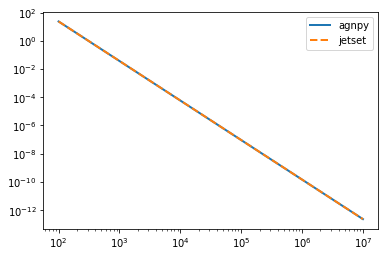

In [8]:
# check the input electron density
plt.loglog(blob.gamma, blob.n_e(blob.gamma), lw=2, ls="-", label="agnpy")
plt.loglog(jet.electron_distribution.gamma, jet.electron_distribution.n_gamma, lw=2, ls="--", label="jetset")
plt.legend()
plt.show()

In [ ]:
jet.eval()

In [ ]:
x, y = jet.get_SED_points()

In [ ]:
plt.loglog(x, y, lw=2, label="jetset")
plt.loglog(nu, sed_synch + sed_ssc, lw=2, ls="--", label="agnpy")
plt.legend()
plt.ylim([1e-12, 1e-8])
plt.xlabel(r"$\nu / Hz$")
plt.ylabel(r"$\nu F_{\nu} / (erg\,cm^{-2}\,s^{-1})$")